In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import torch.optim as optim
import matplotlib.pyplot as plt
import sympy as sp
import os
import argparse

In [2]:
EPOCHS = 800
INPUT_DIM = 4
HIDDEN_DIM = 16
NUM_CLASSES = 3
MODEL_PATH = "iris_model.pth"


In [3]:
#The iris dataset contains measurements from 150 iris flowers belonging to three different species:
# Sepal Length,x1
# Sepal Width,x2
# Petal Length,x3
# Petal Width,x4
# We wish to Train a 2-hidden layer feedforward neural network with sparse connections
#It should take the output of neural network as input and constructs a symbolic equation representing the network’s output.
def load_data():
    iris_dataset = load_iris()
    X, y = iris_dataset.data, iris_dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


In [4]:
total_size = [INPUT_DIM] + [HIDDEN_DIM, HIDDEN_DIM] + [NUM_CLASSES]
total_size


[4, 16, 16, 3]

In [5]:
# Designing the neural network
class FeedForward(nn.Module):
    def __init__(self, sparsity = 0.3):
        super(FeedForward, self).__init__()
        layers = []
        total_size = [INPUT_DIM] + [HIDDEN_DIM, HIDDEN_DIM] + [NUM_CLASSES]
        for i in range(len(total_size) - 1):
            layers.append(nn.Linear(total_size[i], total_size[i+1]))
            layers.append(nn.ReLU() if i < len(total_size) - 2 else nn.Identity())
        
        self.model = nn.Sequential(*layers)
        self.sparsity = sparsity
        self.apply_sparsity()
    
    def apply_sparsity(self): #andomly zeroing out weights in linear layers
        with torch.no_grad():
            for layer in self.model:
                if isinstance(layer, nn.Linear):
                    mask = torch.rand(layer.weight.size()) > self.sparsity
                    layer.weight.data *= mask
    
    def forward(self, x):
        return self.model(x)


In [6]:
# Training the model with iris dataset
def train(plot_curve=False):
    
    model = FeedForward()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    
    X_train, X_test, y_train, y_test = load_data()
    print("Model Training started...")
    
    train_loss = []
    
    for epoch in range(EPOCHS):
        
        inputs = torch.tensor(X_train, dtype=torch.float32)
        target = torch.tensor(y_train, dtype=torch.long)  
        output = model(inputs)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())  
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')
            
    if plot_curve:
        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, label='Training Loss', marker='o')
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.savefig("train_loss.png")
        
    print("Saving the trained model")
    torch.save(model.state_dict(), MODEL_PATH)


In [7]:
# Checking for train and test accuracy    
def inference():
    
    model = FeedForward()
    model.load_state_dict(torch.load(MODEL_PATH))
    X_train, X_test, y_train, y_test = load_data()
    train_predictions, test_predictions = [], []
    model.eval()
    
    X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
    
    with torch.no_grad():
        train_output = model(X_train_tensor)
        test_output = model(X_test_tensor)
        _, train_prediction = torch.max(train_output.data, 1)
        _, test_prediction = torch.max(test_output.data, 1) # calculates the class
        
        train_predictions.append(train_prediction)
        test_predictions.append(test_prediction)
    
    train_accuracy = np.sum(train_predictions == y_train) / len(y_train)
    test_accuracy = np.sum(test_predictions == y_test) / len(y_test)
    
    print("Train Accuracy : {}".format(train_accuracy))
    print("Test Accuracy : {}".format(test_accuracy))
        


In [8]:
# Creating the equation using weights and biases
def create_eqn(input_values):
    
    print("Constructing the symbolic equation \n")
    model = FeedForward()
    model.load_state_dict(torch.load(MODEL_PATH))
    
    W, b = [], []
    for layer in model.model:
        if isinstance(layer, nn.Linear):
            W.append(sp.Matrix(layer.weight.detach().numpy())) #weight matrix
            b.append(sp.Matrix(layer.bias.detach().numpy())) #bias
    
    x = sp.symbols('x0:4')  
    X = sp.Matrix([x[0], x[1], x[2], x[3]])
    
    # Construct the symbolic equation
    z1 = W[0]*X + b[0] # X is input, z1 intermediate value
    a1 = sp.Matrix([sp.Max(0, z1[i]) for i in range(z1.rows)]) #applying relu activation function element-wise to each entry of z1.
    z2 = W[1]*a1 + b[1]
    a2 = sp.Matrix([sp.Max(0, z2[i]) for i in range(z2.rows)])
    output = W[2]*a2 + b[2]
    
    # Substitute input values and evaluate
    x_subs = {x[i]: input_values[i] for i in range(4)}
    output_evaluated = output.subs(x_subs)
    output_numerical = [output_evaluated[i].evalf() for i in range(output.rows)]
    
    index = np.argmax(np.max(output_numerical))
    print('The symbolic equation is: \n ')
    print(output)
    print('\n')
    return output_numerical, index


Model Training started...
Epoch [10/800], Loss: 0.9853
Epoch [20/800], Loss: 0.8903
Epoch [30/800], Loss: 0.7975
Epoch [40/800], Loss: 0.7105
Epoch [50/800], Loss: 0.6045
Epoch [60/800], Loss: 0.4859
Epoch [70/800], Loss: 0.3889
Epoch [80/800], Loss: 0.3024
Epoch [90/800], Loss: 0.2261
Epoch [100/800], Loss: 0.1694
Epoch [110/800], Loss: 0.1309
Epoch [120/800], Loss: 0.1068
Epoch [130/800], Loss: 0.0920
Epoch [140/800], Loss: 0.0825
Epoch [150/800], Loss: 0.0762
Epoch [160/800], Loss: 0.0718
Epoch [170/800], Loss: 0.0686
Epoch [180/800], Loss: 0.0662
Epoch [190/800], Loss: 0.0643
Epoch [200/800], Loss: 0.0627
Epoch [210/800], Loss: 0.0615
Epoch [220/800], Loss: 0.0604
Epoch [230/800], Loss: 0.0595
Epoch [240/800], Loss: 0.0587
Epoch [250/800], Loss: 0.0580
Epoch [260/800], Loss: 0.0574
Epoch [270/800], Loss: 0.0568
Epoch [280/800], Loss: 0.0563
Epoch [290/800], Loss: 0.0559
Epoch [300/800], Loss: 0.0554
Epoch [310/800], Loss: 0.0550
Epoch [320/800], Loss: 0.0547
Epoch [330/800], Loss: 

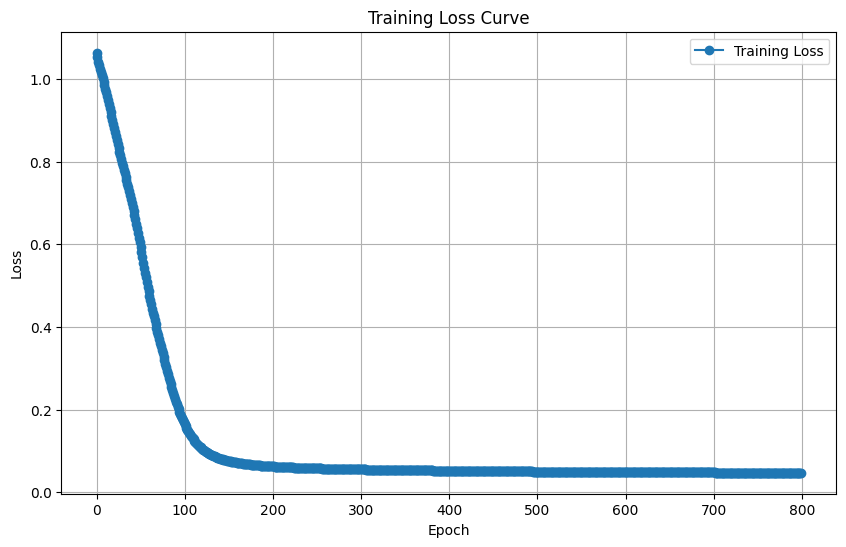

In [9]:

import sys
#user can channge the input values x1,x2,x3,x4 as desired
x1=0.2
x2=0.3
x3=0.4
x4=0.5
sys.argv = ['{x1} {x2} {x3} {x4}']
if __name__ == "__main__":
    
    train(plot_curve=True)
    
    inference()

    parser = argparse.ArgumentParser(description='Example with non-optional arguments')
    parser.add_argument("--x1", type = float, default = 0.1)
    parser.add_argument("--x2", type = float, default = 0.1)
    parser.add_argument("--x3", type = float, default = 0.1)
    parser.add_argument("--x4", type = float, default = 0.1)
    args = parser.parse_args()
    
    inputs = [args.x1, args.x2, args.x3, args.x4]
    
    res, index = create_eqn(inputs)
    
    print("Predicted output: {}".format(res))
    print("Class predictied: {}".format(index))